In [1]:
from datasets import load_dataset, Video

dataset = load_dataset("mmnist-dataset/huggingface-arrow-format/mmnist-easy", split='train')

/Users/maksimploter/miniconda3/envs/detection-moving-mnist/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


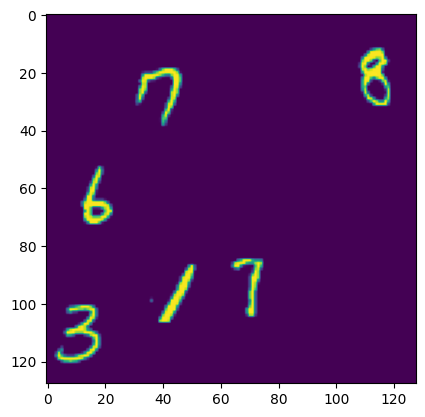

In [28]:
import matplotlib.pyplot as plt
import numpy as np
example = dataset[0]

img = np.array(example['video'][1])

plt.imshow(img)  # First frame
plt.show()

In [20]:
import numpy as np
from PIL import Image, ImageDraw
from torchvision.ops import box_iou
import torch

# Load the dataset
dataset = load_dataset("mmnist-dataset/huggingface-arrow-format/mmnist-easy")

idx = 2

# Select the first training example
example = dataset['train'][idx]

video_frames = example['video']
targets = [{'labels': example['bboxes_labels'][i], 'center_points': example['bboxes_keypoints'][i], 'bboxes': example['bboxes'][i] } for i in range(20)]

processed_frames = []
processed_frames_cp = []
processed_frames_boxes = []
processed_frames_boxes_cover = []
processed_frames_boxes_border = []

colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'magenta', 'lime']

hexs = (
    "042AFF",
    "0BDBEB",
    # "F3F3F3", #2
    "00DFB7",
    # "111F68", #4
    "FF6FDD",
    "FF444F",
    "CCED00",
    "00F344",
    "BD00FF",
    "00B4FF",
    "DD00BA",
    "00FFFF",
    "26C000",
    "01FFB3",
    "7D24FF",
    "7B0068",
    "FF1B6C",
    "FC6D2F",
    "A2FF0B",
)

for frame_idx in range(len(video_frames)):
    # Convert the frame to a numpy array and create a PIL Image
    frame_np = np.array(video_frames[frame_idx])
    # Ensure the data type is uint8 (assuming values are 0-255)
    if frame_np.dtype != np.uint8:
        frame_np = frame_np.astype(np.uint8)
    frame_pil = Image.fromarray(frame_np)
    frame_cp_pil = Image.fromarray(frame_np)
    frame_boxes_pil = Image.fromarray(frame_np)
    frame_boxes_cover_pil = Image.fromarray(frame_np)
    frame_boxes_border_pil = Image.fromarray(frame_np)
    if frame_pil.mode != "RGB":
        frame_pil = frame_pil.convert("RGB")
        frame_cp_pil = frame_cp_pil.convert("RGB")
        frame_boxes_pil = frame_boxes_pil.convert("RGB")
        frame_boxes_cover_pil = frame_boxes_cover_pil.convert("RGB")
        frame_boxes_border_pil = frame_boxes_border_pil.convert("RGB")
    draw = ImageDraw.Draw(frame_pil)
    draw_cp = ImageDraw.Draw(frame_cp_pil)
    draw_boxes = ImageDraw.Draw(frame_boxes_pil)
    draw_boxes_cover = ImageDraw.Draw(frame_boxes_cover_pil)
    draw_boxes_border = ImageDraw.Draw(frame_boxes_border_pil)
    
    # Get the current frame's targets
    current_target = targets[frame_idx]
    labels = current_target['labels']
    centers = current_target['center_points']
    bboxes = current_target['bboxes']
    
    bboxes_tensor = torch.tensor(bboxes, dtype=torch.float32)
    
    # convert xywh to xyxy format
    bboxes_tensor = torch.cat(
        (bboxes_tensor[:, :2] - bboxes_tensor[:, 2:] / 2, 
         bboxes_tensor[:, :2] + bboxes_tensor[:, 2:] / 2), 
        dim=1
    )
    
    gt_iou_matrix = box_iou(bboxes_tensor, bboxes_tensor)
    gt_iou_matrix.fill_diagonal_(0)
    overlaps_exist = (gt_iou_matrix > 0.1).any(dim=1)
    overlap_gt_indices = torch.where(overlaps_exist)[0]
    
    for i, (label, center, bbox) in enumerate(zip(labels, centers, bboxes)):
        x, y, is_visible = center
        
        if is_visible == 2:
            # Convert to pixel coordinates (assuming center at 64,64)
            pixel_x = x
            pixel_y = y
            
            # Draw a red circle
            radius = 2
            
            draw.ellipse(
                [(pixel_x - radius, pixel_y - radius),
                 (pixel_x + radius, pixel_y + radius)],
                fill=f'#{hexs[label]}'
            )
	        
            draw_cp.ellipse(
                [(pixel_x - radius, pixel_y - radius),
                 (pixel_x + radius, pixel_y + radius)],
                fill=f'#{hexs[label]}'
            )
            
        # Draw a bounding box
        bbox_x_min, bbox_y_min, w, h = bbox
        bbox_x_max = bbox_x_min + w
        bbox_y_max = bbox_y_min + h
        draw.rectangle(
            [bbox_x_min, bbox_y_min, bbox_x_max, bbox_y_max],
            outline=f'#{hexs[label]}',
            width=1
        )
        draw_boxes.rectangle(
            [bbox_x_min, bbox_y_min, bbox_x_max, bbox_y_max],
            outline=f'#{hexs[label]}',
            width=1
        )

        text = str(label)
        
        if i in overlap_gt_indices:
            # Draw a cover box for overlapping ground truth
            draw_boxes_cover.rectangle(
                [bbox_x_min, bbox_y_min, bbox_x_max, bbox_y_max],
                outline=f'#{hexs[label]}',
                width=1
            )
            draw_boxes_cover.text((bbox_x_min + 1, bbox_y_min + 1), text, fill=f'#{hexs[label]}')
	        
        if bbox_x_min <= 0 or bbox_y_min <= 0 or bbox_x_max >= frame_pil.width-1 or bbox_y_max >= frame_pil.height-1:
            draw_boxes_border.rectangle(
                [bbox_x_min, bbox_y_min, bbox_x_max, bbox_y_max],
                outline=f'#{hexs[label]}',
                width=1
            )
            draw_boxes_border.text((bbox_x_min + 1, bbox_y_min + 1), text, fill=f'#{hexs[label]}') 
        
        # Draw the label next to the point
        draw.text((bbox_x_min + 1, bbox_y_min + 1), text, fill=f'#{hexs[label]}')
        
        if is_visible:
            draw_cp.text((bbox_x_min + 1, bbox_y_min + 1), text, fill=f'#{hexs[label]}')
        draw_boxes.text((bbox_x_min + 1, bbox_y_min + 1), text, fill=f'#{hexs[label]}')
    
    processed_frames.append(frame_pil)
    processed_frames_cp.append(frame_cp_pil)
    processed_frames_boxes.append(frame_boxes_pil)
    processed_frames_boxes_cover.append(frame_boxes_cover_pil)
    processed_frames_boxes_border.append(frame_boxes_border_pil)

# Save as GIF
processed_frames[0].save(
    f'./annotated_video_{idx}.gif',
    save_all=True,
    append_images=processed_frames[1:],
    duration=200,  # Adjust duration between frames (ms)
    loop=0         # Loop indefinitely
)
processed_frames_cp[0].save(
    f'./annotated_video_cp_{idx}.gif',
    save_all=True,
    append_images=processed_frames_cp[1:],
    duration=200,  # Adjust duration between frames (ms)
    loop=0         # Loop indefinitely
)
processed_frames_boxes[0].save(
    f'./annotated_video_boxes_{idx}.gif',
    save_all=True,
    append_images=processed_frames_boxes[1:],
    duration=200,  # Adjust duration between frames (ms)
    loop=0         # Loop indefinitely
)
processed_frames_boxes_cover[0].save(
    f'./annotated_video_boxes_cover_{idx}.gif',
    save_all=True,
    append_images=processed_frames_boxes_cover[1:],
    duration=200,  # Adjust duration between frames (ms)
    loop=0         # Loop indefinitely
)
processed_frames_boxes_border[0].save(
    f'./annotated_video_boxes_border_{idx}.gif',
    save_all=True,
    append_images=processed_frames_boxes_border[1:],
    duration=200,  # Adjust duration between frames (ms)
    loop=0         # Loop indefinitely
)

print("GIF created successfully!")

GIF created successfully!
